# Monsters and Mixtures

In [294]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import theano
import arviz as az

import warnings
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.simplefilter(action="ignore", category=FutureWarning)

### Ordered categorical outcomes

##### Code 11.1

In [2]:
d = pd.read_csv("../../data/Trolley.csv", sep=";")

##### Code 11.2 & Figure 11.1a

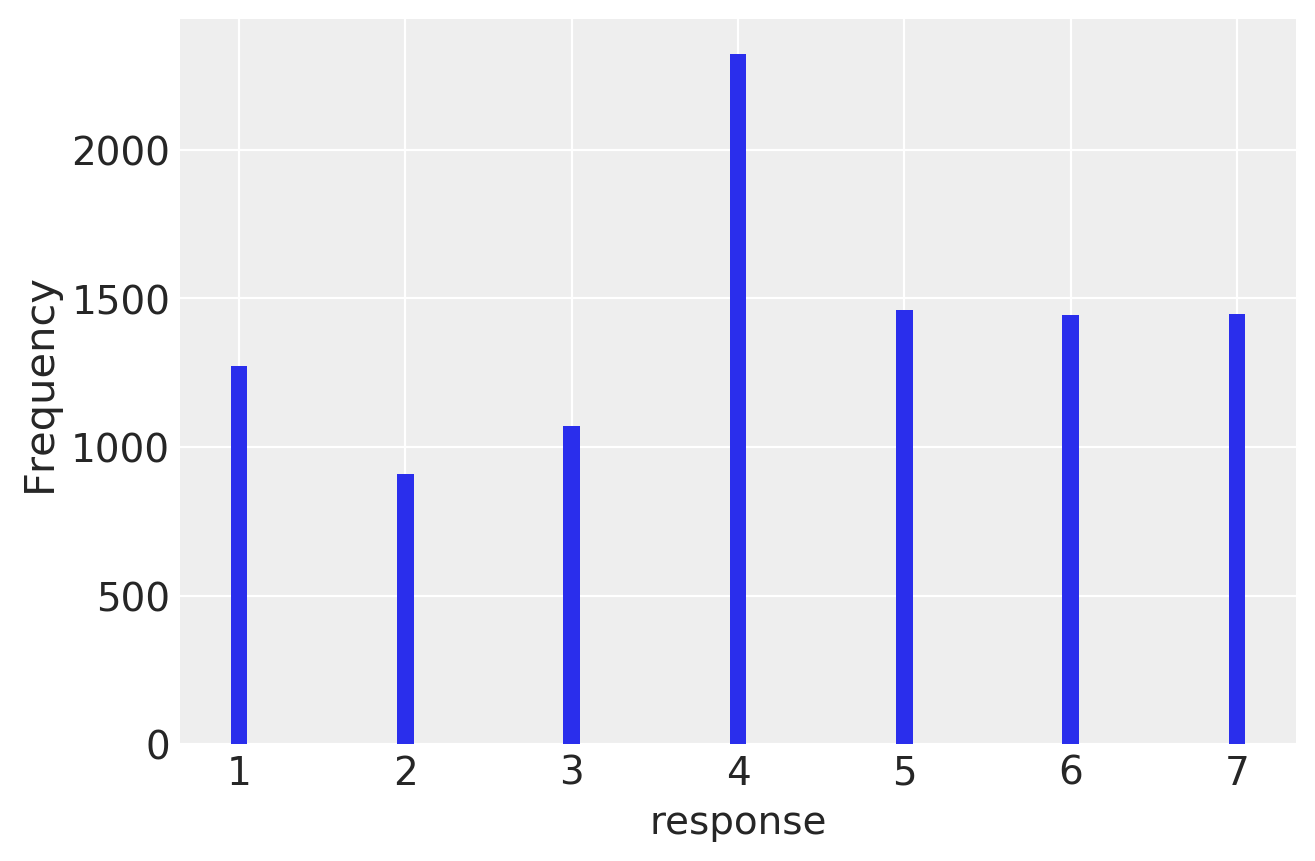

In [3]:
ax = d.response.plot(kind="hist", rwidth=0.1, bins=np.arange(8)+0.5)
ax.set_xlabel("response", fontsize=14);

##### Code 11.3 & Figure 11.1b

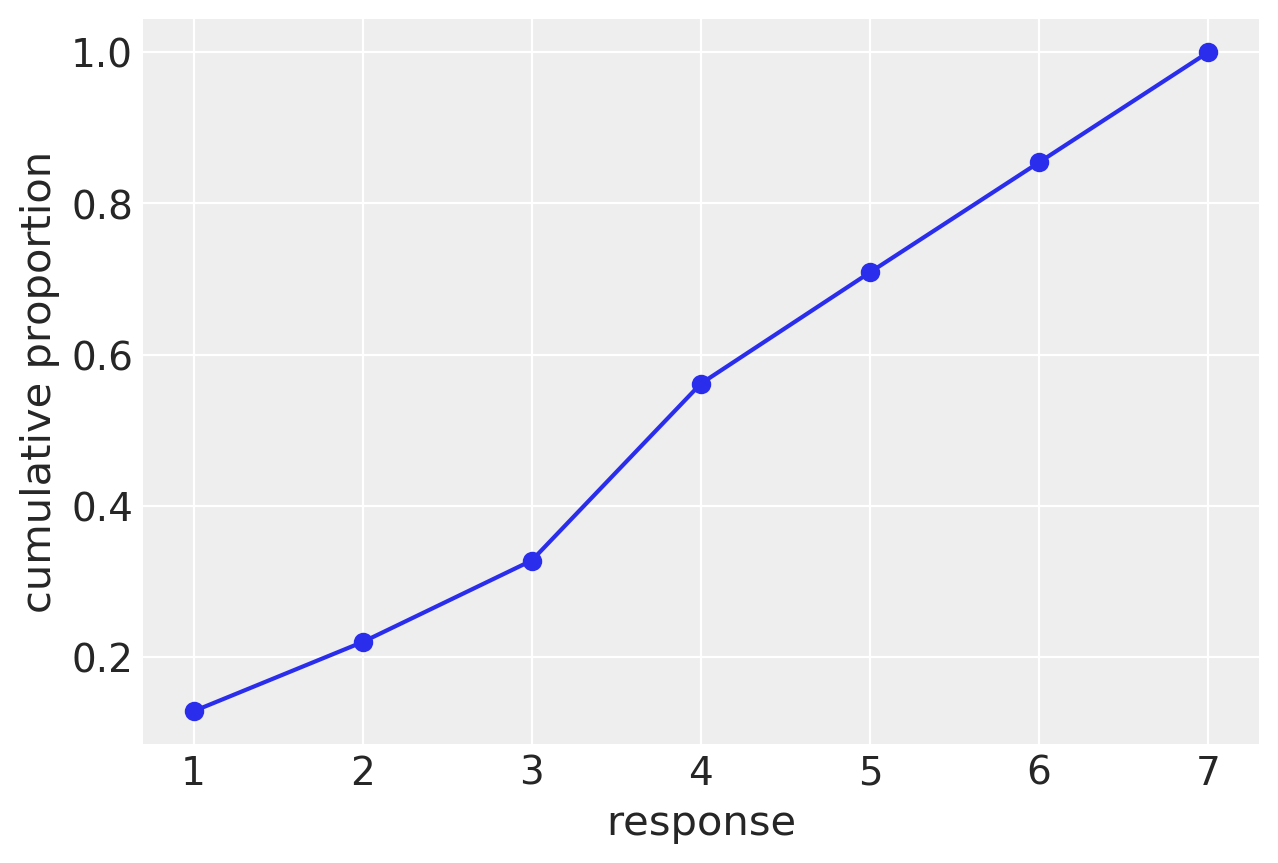

In [4]:
ax = d.response.value_counts().sort_index().cumsum().div(d.shape[0]).plot(marker="o")
ax.set_xlabel("response")
ax.set_ylabel("cumulative proportion");

##### Code 11.4 & Figure 11.1c

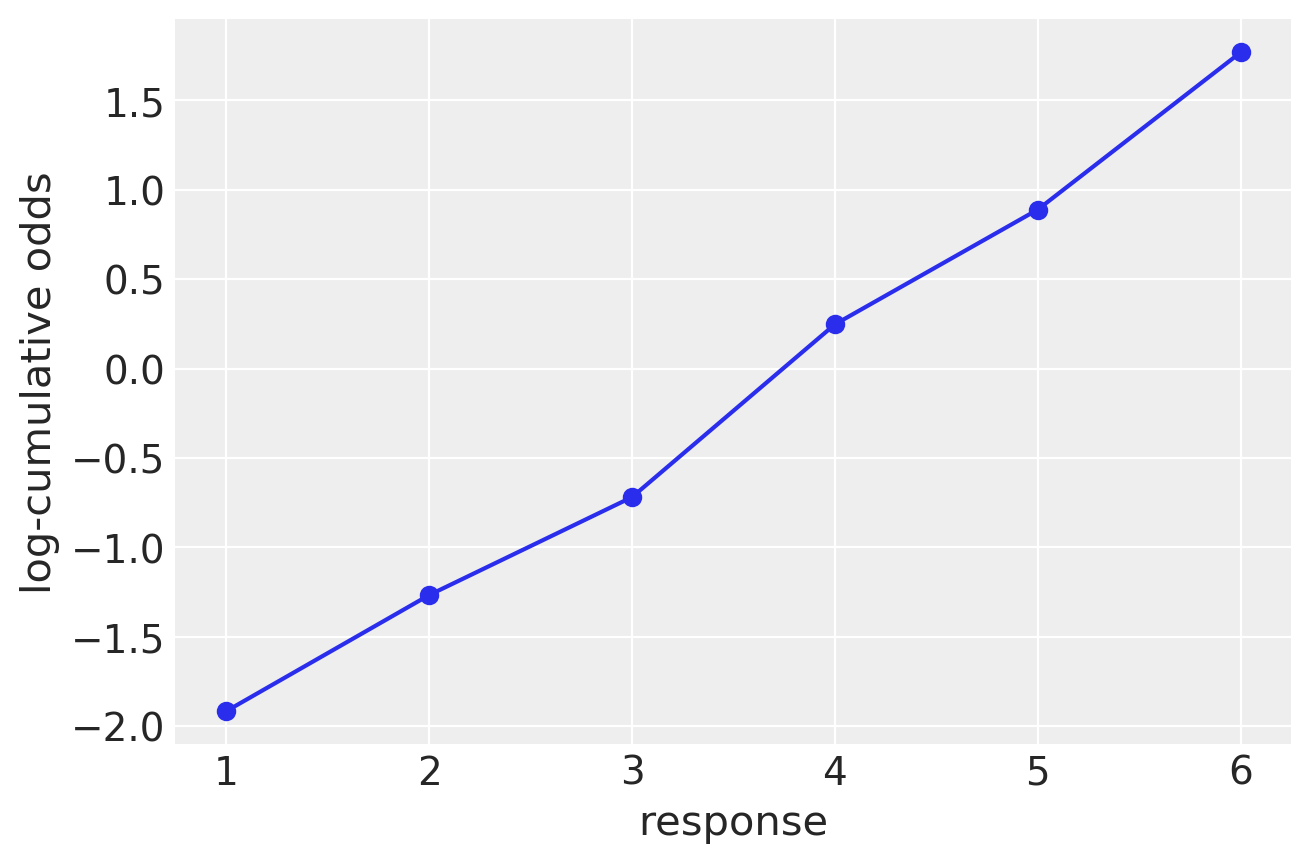

In [5]:
logit = lambda x: np.log(x / (1-x))
ax = d.response.value_counts().sort_index().cumsum().div(d.shape[0]).pipe(logit).plot(marker="o")
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative odds");

##### Figure 11.2

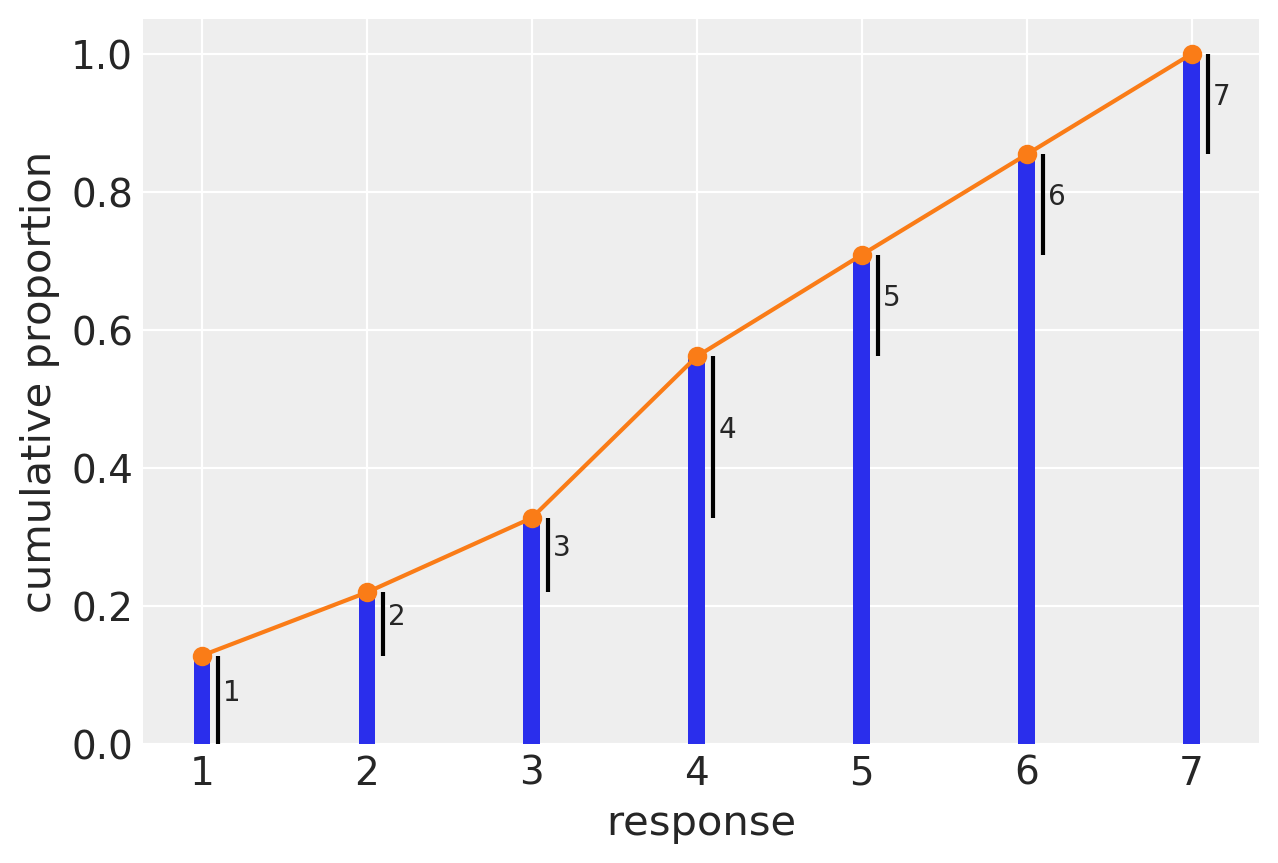

In [6]:
val = d.response.value_counts().sort_index().cumsum().div(d.shape[0])
val_diff = val.diff()
val_diff[1] = val[1]
plt.hist(d.response, rwidth=0.1, bins=np.arange(8)+0.5, cumulative=True, density=True)
ax = val.plot(marker="o")
ax.vlines(np.arange(7)+1.1, val - val_diff,val)
for i, xy in enumerate(zip(np.arange(7)+1.13,val - val_diff / 2)):
    ax.annotate(str(i+1), xy)
    
ax.set_xlabel("response")
ax.set_ylabel("cumulative proportion");

##### Code 11.5

In [7]:
with pm.Model() as m11_1:
    a = pm.Normal("a", mu=0, sd=10, transform=pm.distributions.transforms.ordered, shape=6, testval=np.arange(6) - 2.5)
    response = pm.OrderedLogistic("response", 0, a, observed=d.response - 1)
    map_11_1 = pm.find_MAP()

logp = -18,941, ||grad|| = 0.45229: 100%|██████████| 14/14 [00:00<00:00, 861.92it/s]  


##### Code 11.6

In [8]:
map_11_1["a"]

array([-1.9160707 , -1.26658298, -0.71862013,  0.24778795,  0.88986631,
        1.76937289])

##### Code 11.7

In [9]:
logistic = lambda x: np.exp(x) / (1 + np.exp(x))
logistic(map_11_1["a"])

array([0.12830038, 0.21984275, 0.32769691, 0.56163196, 0.70886258,
       0.85437967])

##### Code 11.8

In [10]:
trace_m11_1 = pm.sample(1000, tune=1000, model=m11_1)
summary = az.summary(trace_m11_1, credible_interval=0.89)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 368.79draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.918,0.031,-1.968,-1.871,0.001,0.0,2031.0,2028.0,2032.0,1325.0,1.0
a[1],-1.267,0.024,-1.305,-1.228,0.000,0.0,2387.0,2376.0,2394.0,1625.0,1.0
a[2],-0.719,0.021,-0.755,-0.686,0.000,0.0,2594.0,2594.0,2578.0,1828.0,1.0
a[3],0.248,0.020,0.215,0.277,0.000,0.0,2596.0,2596.0,2599.0,1733.0,1.0
a[4],0.890,0.022,0.853,0.924,0.000,0.0,2778.0,2778.0,2768.0,1574.0,1.0
a[5],1.770,0.028,1.721,1.813,0.001,0.0,2811.0,2811.0,2808.0,1789.0,1.0


##### Code 11.9

In [11]:
ordered_logistic_proba = lambda x: np.diff(np.insert(np.append(logistic(x), 1), 0, 0))
pk = ordered_logistic_proba(map_11_1["a"])

##### Code 11.10

In [12]:
np.sum(pk * (np.arange(7)+1))

4.19928574748888

##### Code 11.11

In [13]:
pk = ordered_logistic_proba(map_11_1["a"] - 0.5)

##### Code 11.12

In [14]:
np.sum(pk * (np.arange(7)+1))

4.729732430407035

##### Code 11.13

In [16]:
with pm.Model() as m11_2:
    a = pm.Normal("a", mu=0, sd=10, transform=pm.distributions.transforms.ordered, shape=6, testval=map_11_1['a'])
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    phi = pm.Deterministic("phi", b[0] * d.action + b[1] * d.intention + b[2] * d.contact)
    response = pm.OrderedLogistic("response", phi, a, observed=d.response - 1)
    trace_m11_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:02<00:00, 32.69draws/s]


##### Code 11.14

In [17]:
with pm.Model() as m11_3:
    a = pm.Normal("a", mu=0, sd=10, transform=pm.distributions.transforms.ordered, shape=6, testval=trace_m11_2['a'].mean(axis=0))
    b = pm.Normal("b", mu=0, sd=10, shape=5)
    phi = pm.Deterministic("phi", b[0] * d.action + b[1] * d.intention + b[2] * d.contact + b[3] * d.action * d.intention + b[4] * d.contact * d.intention)
    response = pm.OrderedLogistic("response", phi, a, observed=d.response - 1)
    trace_m11_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:52<00:00, 23.21draws/s]


##### Code 11.15

In [18]:
def coefs(trace):
    varnames = ["a", "b"] if "b" in trace.varnames else ["a"]
    return az.summary(trace, var_names=varnames)["mean"]


In [19]:
coeftab = pd.concat([coefs(trace_m11_1), coefs(trace_m11_2), coefs(trace_m11_3)], axis=1)
coeftab.columns = ["m11_1", "m11_2", "m11_3"]
coeftab

,m11_1,m11_2,m11_3
a[0],-1.918,-2.836,-2.637
a[1],-1.267,-2.154,-1.940
a[2],-0.719,-1.572,-1.344
a[3],0.248,-0.550,-0.309
a[4],0.890,0.119,0.363
a[5],1.770,1.025,1.269
b[0],NaN,-0.708,-0.473
b[1],NaN,-0.719,-0.283
b[2],NaN,-0.961,-0.334
b[3],NaN,NaN,-0.447


##### Code 11.16

In [20]:
az.compare({f"m11_{i}": eval(f"trace_m11_{i}") for i in [1,2,3]})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m11_3,0,36929.4,11.1498,0,1,59.1032,0,False,deviance
m11_2,1,37090.5,9.29878,161.044,2.04003e-21,78.7564,25.7211,False,deviance
m11_1,2,37854.5,6.01082,925.064,2.60321e-155,83.3633,62.7247,False,deviance


##### Code 11.17

In [21]:
post = pm.sample_posterior_predictive(trace_m11_3, 1000, model=m11_3)

/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


##### Code 11.18 & Code 11.18 & Figure 11.3

In [24]:
pp_df = pd.DataFrame(np.array([[0, 0, 0],
                               [0, 0, 1],
                               [1, 0, 0],
                               [1, 0, 1],
                               [0, 1, 0],
                               [0, 1, 1]]),
                     columns=['action', 'contact', 'intention'])

In [23]:
with m11_3:
    phi_test = pm.Deterministic("phi_test", b[0] * pp_df.action + b[1] * pp_df.intention + b[2] * pp_df.contact + b[3] * pp_df.action * pp_df.intention + b[4] * pp_df.contact * pp_df.intention)
    trace_test = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:51<00:00, 23.33draws/s]
/Users/hamzaiqb/.pyenv/versions/miniconda3-4.3.30/envs/statrethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]


In [53]:
phi = (
    trace_test["b"][:,0] * pp_df.action[:, None] 
    + trace_test["b"][:,1] * pp_df.intention[:, None] 
    + trace_test["b"][:,2] * pp_df.contact[:, None]
    + trace_test["b"][:,3] * pp_df.action[:, None] * pp_df.intention[:, None] 
    + trace_test["b"][:,4] * pp_df.contact[:, None] * pp_df.intention[:, None] 
)

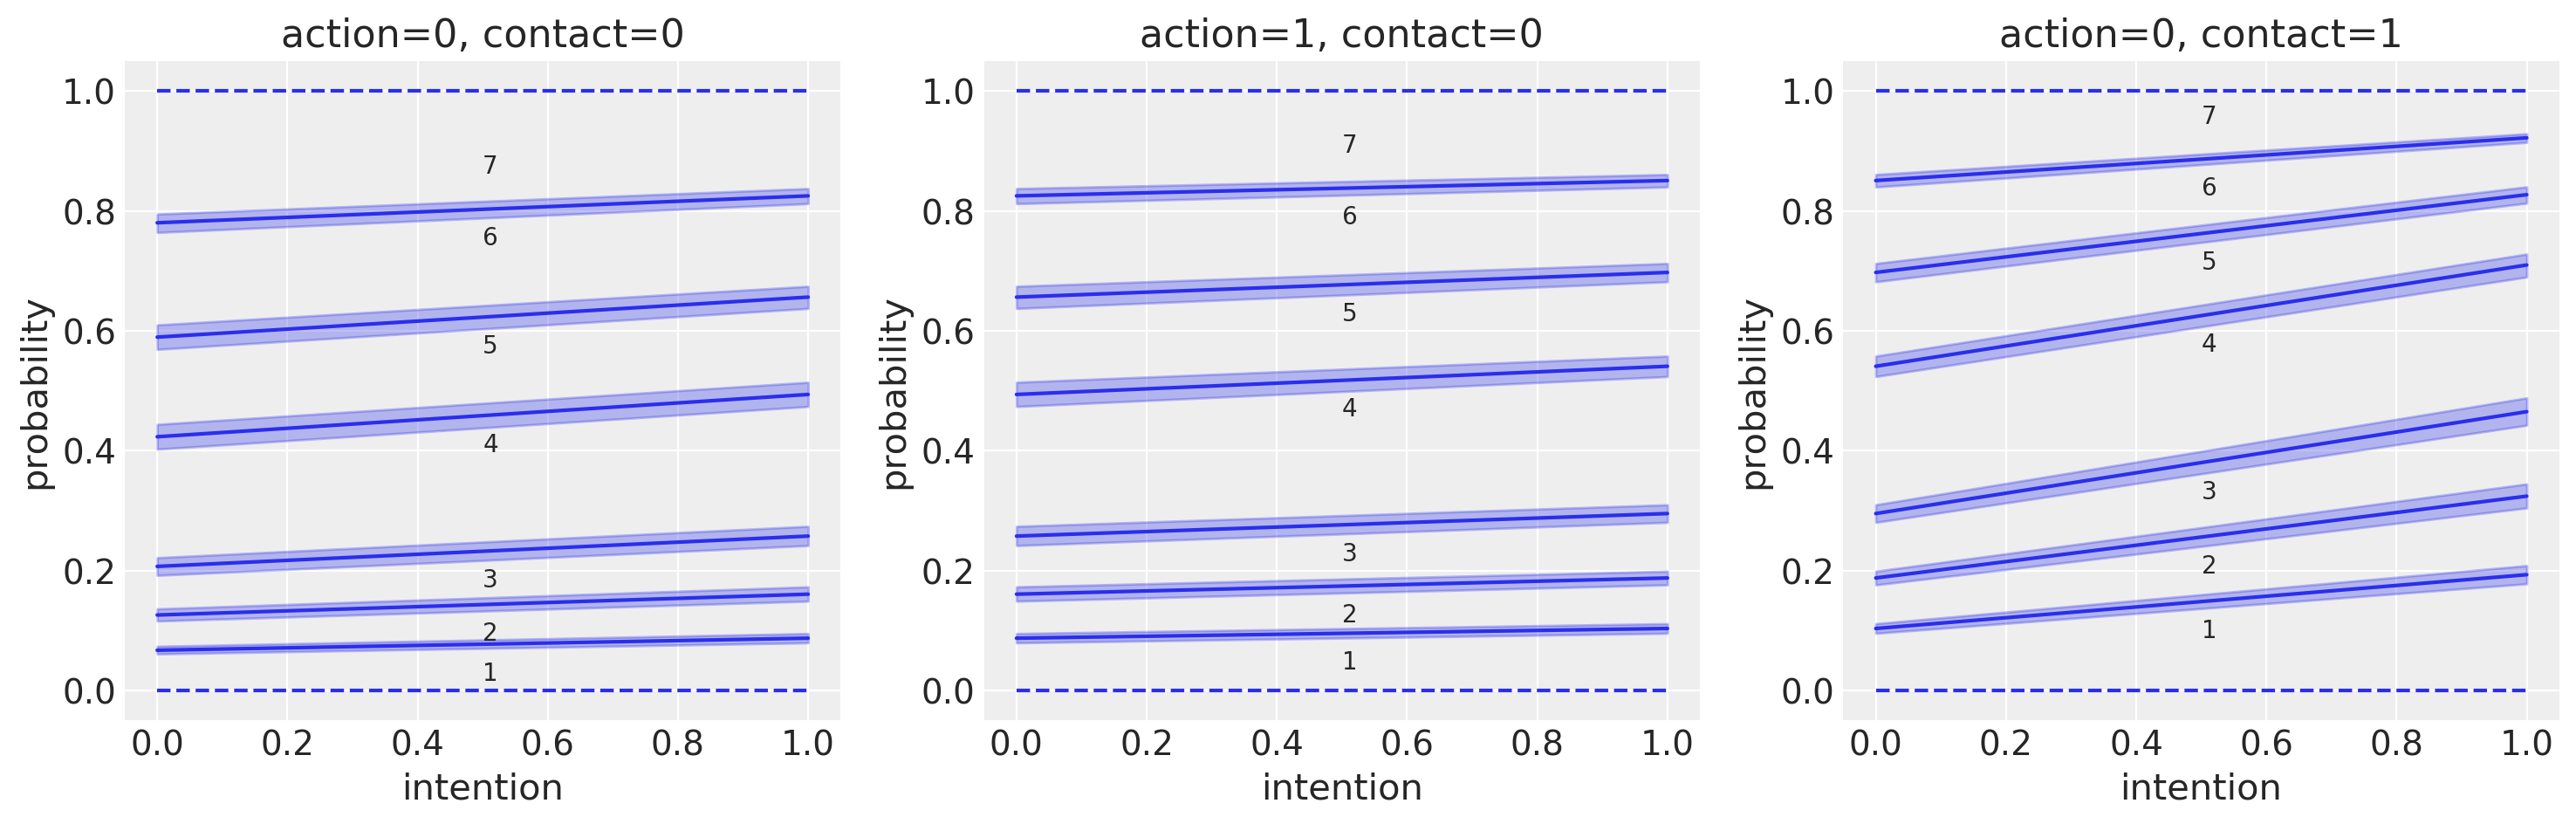

In [271]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

a = trace_test["a"].T
for i, ax in enumerate(axes.flatten()):
    
    phi_I0, phi_I1 = phi[i], phi[i+1]
    p1, p2 = logistic(a - phi_I0), logistic(a - phi_I1)
    p1_avg, p2_avg = p1.mean(1), p2.mean(1)
    
    for k, x in enumerate(zip(p1_avg, p2_avg)):
        ax.plot([0,1], x, "C0")
        ax.annotate(str(k+1), (0.5, (x[0]+ x[1]) / 2 - 0.06))
    ax.annotate(str(k+2), (0.5, (x[0]+ x[1]) / 2 + 0.06))
    
    pct_range = [5/2, 100-5/2]
    p1_pct, p2_pct = np.percentile(p1, pct_range,1), np.percentile(p2, pct_range,1)
    for x1, x2 in zip(p1_pct.T, p2_pct.T):
        lower = [x1[0], x2[0]]
        upper = [x1[1], x2[1]]
        ax.fill_between([0,1], upper, lower, color="C0", alpha=0.3)
    
    ax.hlines([0,1], 0, 1, color="C0", ls="--")
    kA = pp_df.iloc[i*2, :]["action"]
    kC = pp_df.iloc[i*2, :]["contact"]
    ax.set_title(f"action={kA}, contact={kC}")
    ax.set_ylabel("probability")
    ax.set_xlabel("intention")
    ax.set_ylim(-0.05, 1.05);

### Zero Inflated Outcomes

##### Code 11.20

In [289]:
# define parameters
prob_drink = 0.2 # 20% of days
rate_work = 1 # avg 1 manuscript a day

# sample one year of production
N = 365

drink = np.random.binomial(1, prob_drink, N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(rate_work, N)

##### Code 11.21

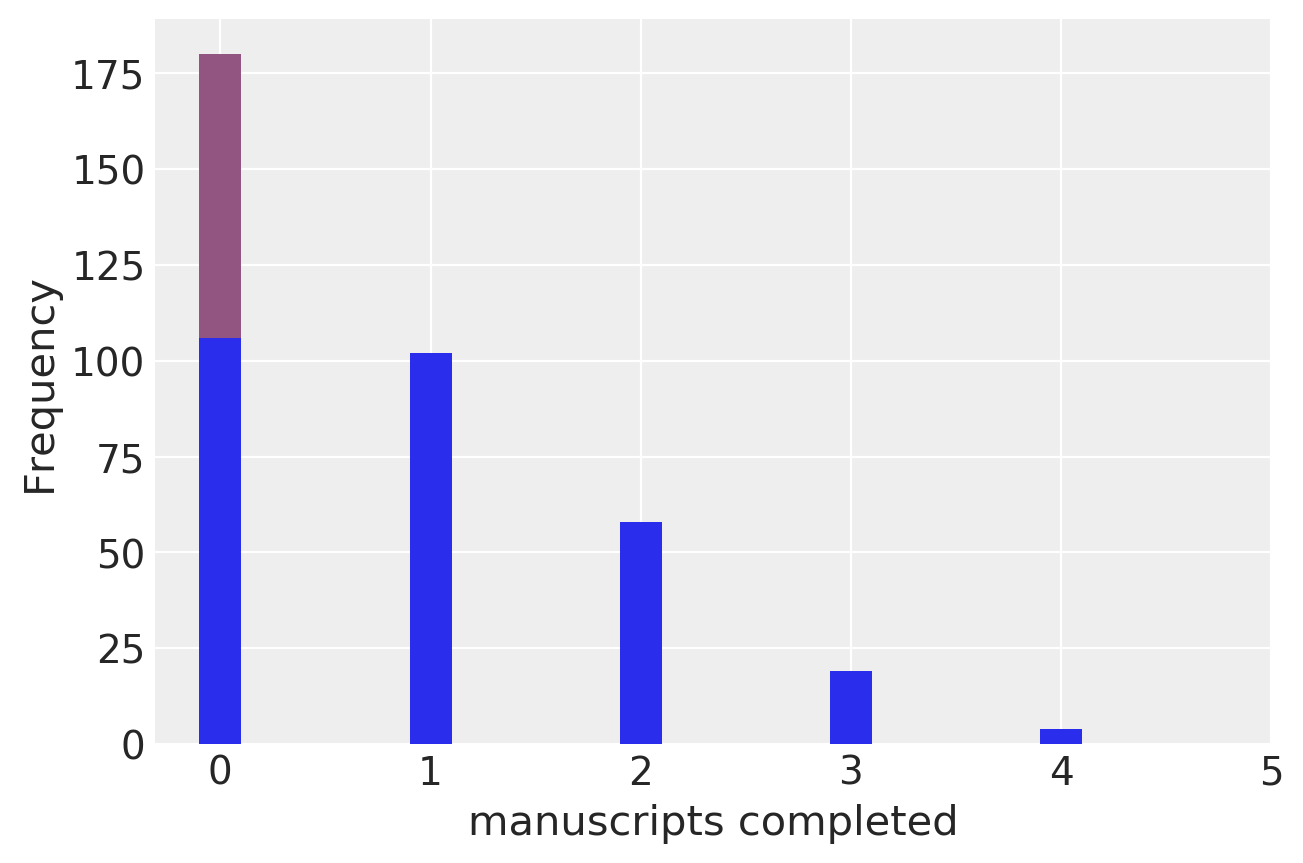

In [282]:
drink_zeros = drink.sum()
work_zeros = (y == 0).sum() - drink_zeros

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, rwidth=0.2)
plt.bar(0., drink_zeros, width=0.2, bottom=work_zeros, color='C1', alpha=.5)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

##### Code 11.22

In [291]:
with pm.Model() as m11_4:
    al = pm.Normal("al", mu=0, sd=10)
    ap = pm.Normal("ap", mu=0, sd=1)
    lam = pm.Deterministic("lambda", pm.math.exp(al))
    p = pm.Deterministic("p", pm.math.invlogit(ap))
    y_obs = pm.ZeroInflatedPoisson("y", psi=p, theta=lam, observed=y)
    trace_m11_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ap, al]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1429.14draws/s]


In [292]:
az.summary(trace_m11_4, var_names=["al", "ap"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
al,0.035,0.089,-0.107,0.178,0.003,0.002,700.0,700.0,698.0,1073.0,1.0
ap,1.146,0.319,0.661,1.637,0.013,0.010,610.0,548.0,700.0,806.0,1.0


##### Code 11.23

In [334]:
logistic(-1.39), np.exp(0.05)

(0.1994077568486685, 1.0512710963760241)

##### Code 11.24

In [295]:
def dzip(x, p, lambda_, log=True):
    ll = p*(x == 0) + (1 - p) * sp.stats.poisson.pmf(x, lambda_)
    
    return np.log(ll) if log else ll

### Over-dispersed outcomes

##### Code 11.25

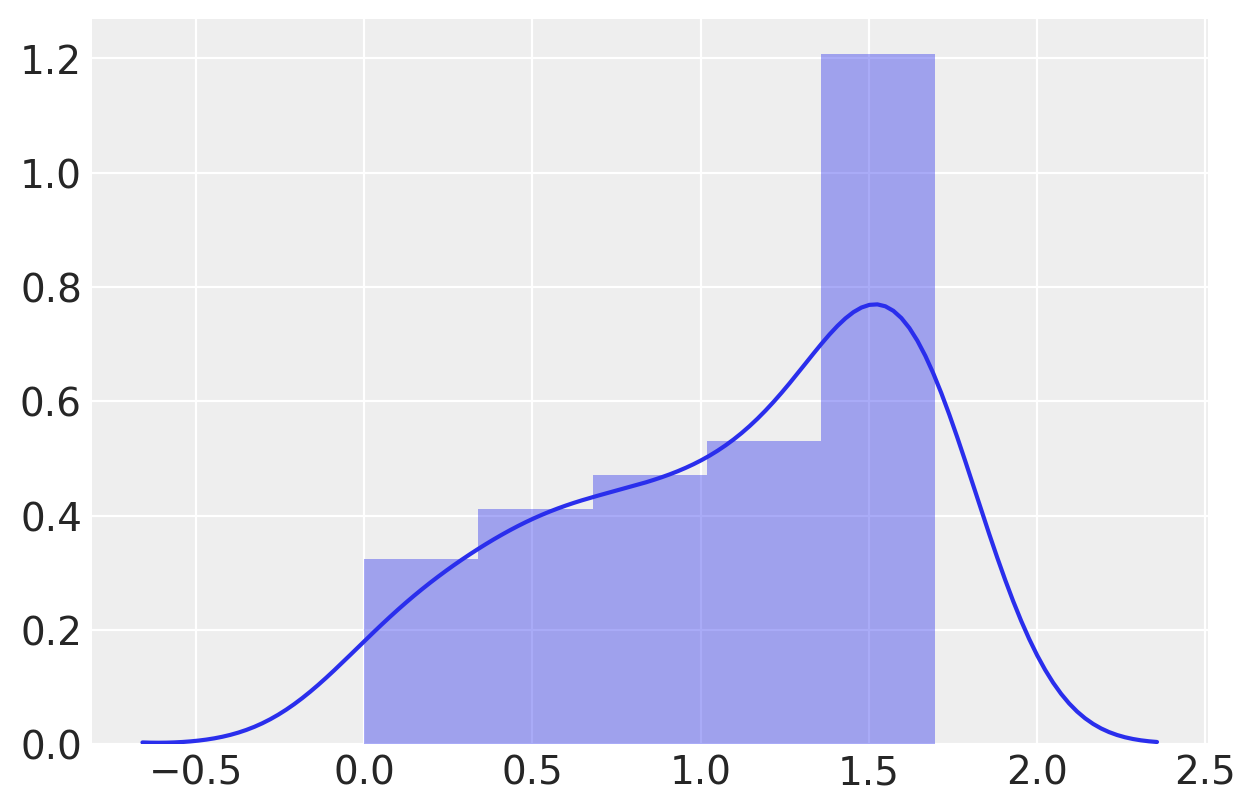

In [329]:
pbar = 0.5
theta = 5
a = pbar * theta
b = (1 - pbar) * theta
x = sp.stats.beta.pdf(np.linspace(0.1, 1, 100), a, b)
sns.distplot(x)

##### Code 11.26

In [330]:
d = pd.read_csv("../../data/UCBadmit.csv", sep=";")

with pm.Model() as m11_5:
    theta = pm.Exponential("theta", 1)
    a = pm.Normal("a", mu=0, sd=2)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a))
    admit_obs = pm.BetaBinomial("admit", alpha = pbar * theta, beta=(1 - pbar) * theta, n=d.applications, observed=d.admit)
    trace_m11_5 = pm.sample(1000, tune=1000)

##### Code 11.27

In [333]:
az.summary(trace_m11_5, credible_interval=0.89, var_names=["a", "theta"])

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.382,0.295,-0.892,0.060,0.008,0.006,1438.0,1273.0,1439.0,1088.0,1.01
theta,2.807,0.972,1.418,4.374,0.027,0.020,1265.0,1143.0,1322.0,1170.0,1.00


##### Code 11.28

In [337]:
np.percentile(logistic(trace_m11_5["a"]), [2.5, 50, 97.5])

array([0.28036012, 0.40429218, 0.55473979])

##### Code 11.29 & Figure 11.5a

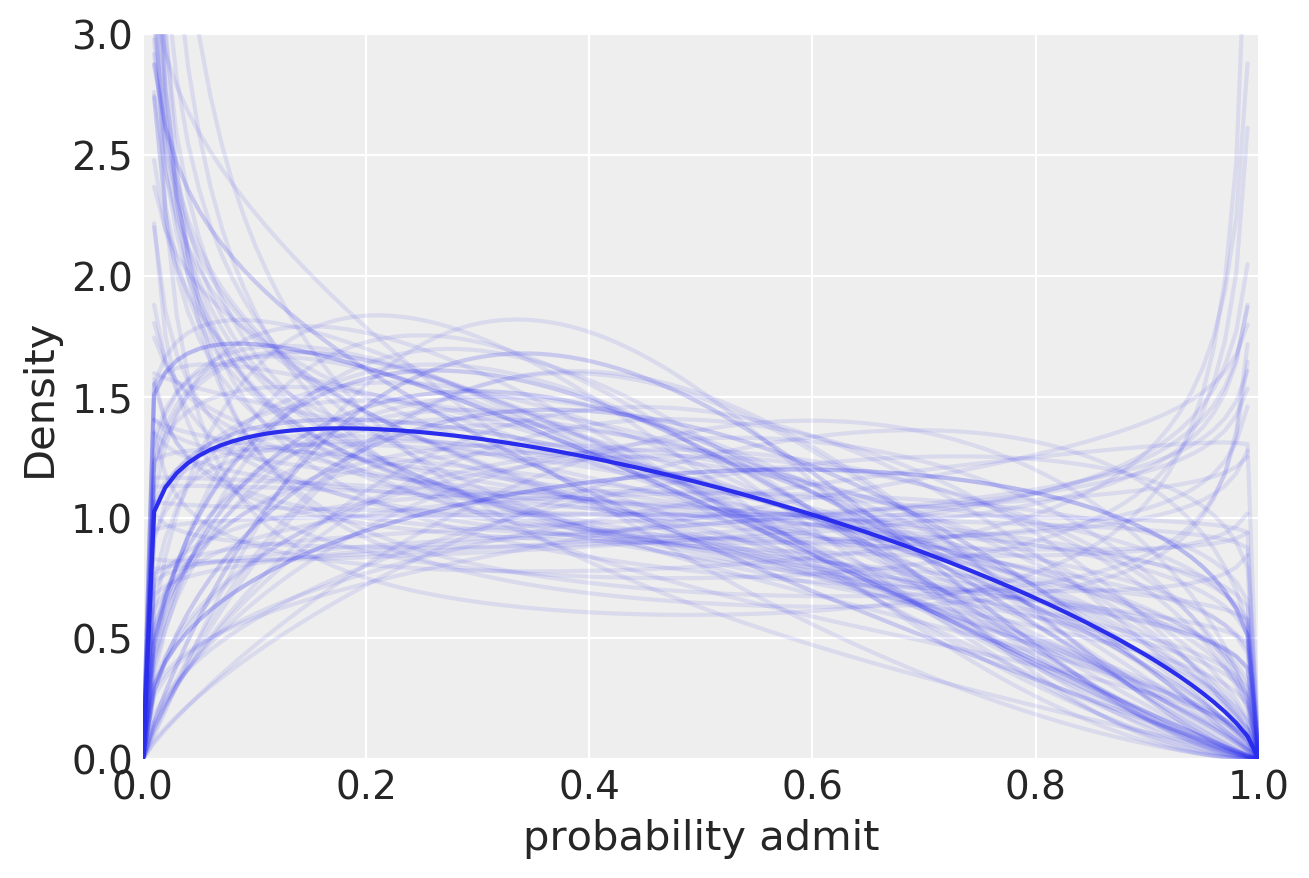

In [341]:
pbar_hat = trace_m11_5['pbar'].mean()
theta_hat = trace_m11_5['theta'].mean()

p_plot = np.linspace(0, 1, 100)

plt.plot(
    p_plot,
    sp.stats.beta.pdf(p_plot, pbar_hat * theta_hat, (1. - pbar_hat) * theta_hat)
);
plt.plot(
    p_plot,
    sp.stats.beta.pdf(
        p_plot[:, np.newaxis],
        trace_m11_5['pbar'][:100] * trace_m11_5['theta'][:100],
        (1. - trace_m11_5['pbar'][:100]) * trace_m11_5['theta'][:100]
    ),
    c='C0', alpha=0.1
);

plt.xlim(0., 1.);
plt.xlabel("probability admit");

plt.ylim(0., 3.);
plt.ylabel("Density");

##### Code 11.30 & Figure 11.5b

In [349]:
pp_trace_11_5 = pm.sample_posterior_predictive(trace_m11_5, 1000, model=m11_5)

x_case = np.arange(d.shape[0])

plt.scatter(
    x_case,
    pp_trace_11_5['admit'].mean(axis=0) / d.applications.values
);
plt.scatter(x_case, d.admit / d.applications);

high = np.percentile(pp_trace_11_5['admit'], 94.5, axis=0) / d.applications.values
plt.scatter(x_case, high, marker='x', c='k');

low = np.percentile(pp_trace_11_5['admit'], 5.5, axis=0) / d.applications.values
plt.scatter(x_case, low, marker='x', c='k');

##### Code 11.31

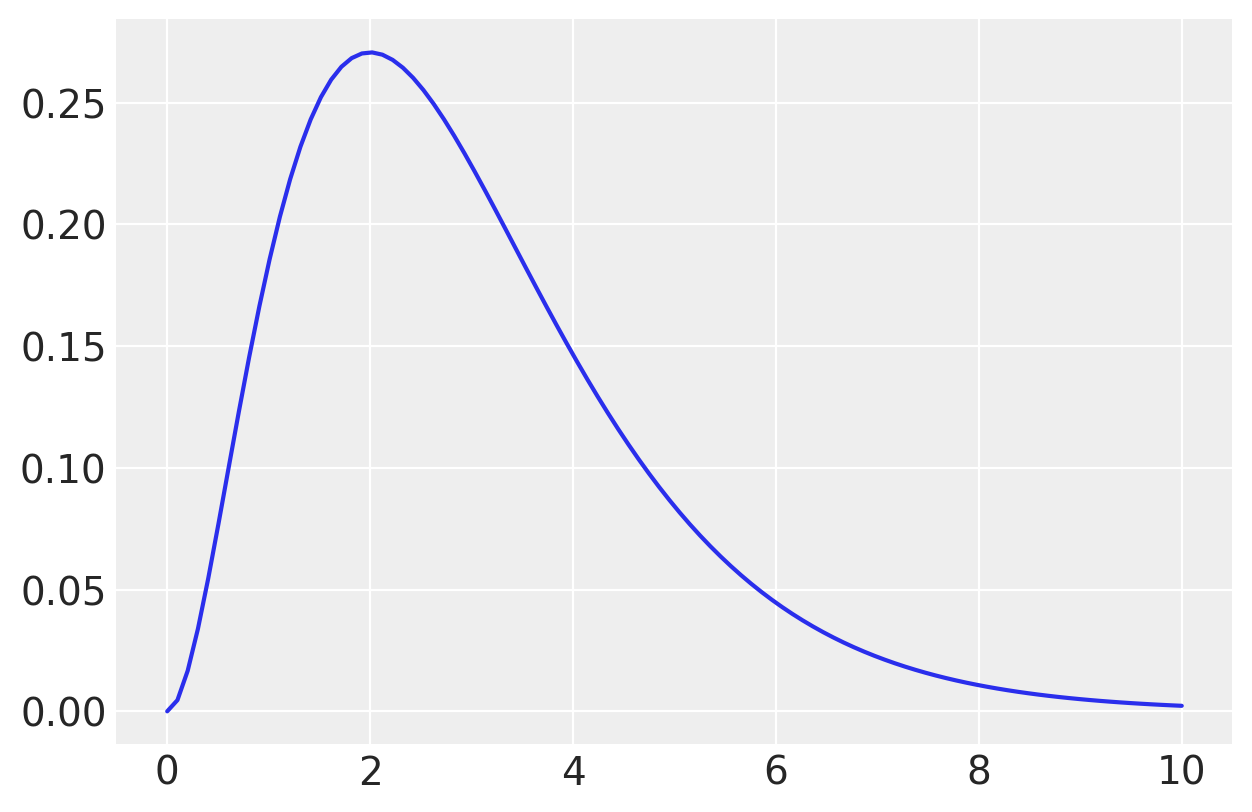

In [350]:
mu = 3
theta = 1
x = np.linspace(0, 10, 100)
plt.plot(x, sp.stats.gamma.pdf(x, mu / theta, scale=theta));

In [ ]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))
